In [1]:
import numpy as np 
import pandas as pd
import math
from scipy.spatial.distance import cdist # Tính khoảng cách giữa các cặp điểm trong 2 tập hợp một cách hiệu quả
import random
import matplotlib.pyplot as plt
%matplotlib inline
rs = 10
rnd = np.random.RandomState(rs)

## Tạo bộ dữ liệu ngẫu nhiên
Ta tạo một bộ dữ liệu ngẫu nhiên gồm 3 cụm có tâm lần lượt là `(2, 2)`, `(8, 3)` và `(3, 6)` với 200 mẫu cho mỗi cụm theo phân phối chuẩn.

### Tạo bộ dữ liệu bằng thư viện numpy
Dữ liệu được tạo ra bằng cách lấy ngẫu nhiên 200 điểm cho mỗi cụm theo phân phối chuẩn có kỳ vọng lần lượt là `(2, 2)`, `(8, 3)` và `(3, 6)`; ma trận hiệp phương sai giống nhau và là ma trận đơn vị cấp 2.

In [2]:
np.random.seed(18) # Cố định dữ liệu random sau mỗi lần chạy là giống nhau
# Danh sách các tâm cụm đồng thời là kỳ vọng để tạo mẫu
means = [[2, 2], [8, 3], [3, 6]]
# Ma trận hiệp phương sai cấp 2
cov = [[1, 0], [0, 1]]
# Số lượng điểm mẫu cho mỗi cụm
N = 200
# Tạo mẫu ngẫu nhiên 200 điểm cho mỗi cụm theo phân phối chuẩn có kỳ vọng (means) và ma trận hiệp phương sai (cov)
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
# Nối X0, X1, X2 thành một bộ dữ liệu lớn
X_np = np.concatenate((X0, X1, X2), axis = 0)
K = 3 # 3 cụm
# Tạo vector cột làm nhãn cho dữ liệu ở trên
y_np = np.asarray([0]*N + [1]*N + [2]*N).T

Mô phỏng dữ liệu vừa tạo bằng đồ thị.

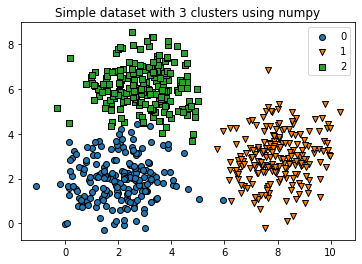

In [3]:
X = X_np
y = y_np
labels = np.unique(y)
marker = ['o', 'v', 's']
#Minh hoạ kết quả
fig, ax = plt.subplots()
for i, m in zip(labels, marker):
    ax.scatter(X[y == i][:, 0], X[y == i][:, 1], edgecolor='k', marker=m)
    
plt.legend(labels)
plt.title('Simple dataset with 3 clusters using numpy')
plt.show()

### Tạo bộ dữ liệu bằng thư viện scikit-learn
Ta dùm hàm `sklean.datasets.make_blobs` để tạo ra một bộ dữ liệu ngẫu nhiên có 3 cụm và 200 điểm dữ liệu cho mỗi cụm theo phân phối chuẩn với các tâm cụm cho trước như trên.

In [4]:
# Khai báo hàm make_blobs từ thư viện sklearn
from sklearn.datasets import make_blobs
# Hàm make_blobs tạo bộ dữ liệu ngẫu nhiên trả về X là danh sách các mẫu và y là danh sách nhãn của các mẫu
X_skl, y_skl = make_blobs(n_samples=600, 
                  n_features=2, 
                  centers=[[2, 2], [8, 3], [3, 6]], 
                  cluster_std=1, 
                  shuffle=True, 
                  random_state=18)

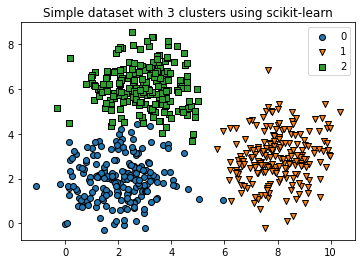

In [5]:
X = X_skl
y = y_skl
labels = np.unique(y)
marker = ['o', 'v', 's']
#Minh hoạ kết quả
fig, ax = plt.subplots()
for i, m in zip(labels, marker):
    ax.scatter(X[y == i][:, 0], X[y == i][:, 1], edgecolor='k', marker=m)

plt.legend(labels)
plt.title('Simple dataset with 3 clusters using scikit-learn')
plt.show()

# Thuật toán K-Means
## Nhắc lại các bước của thuật toán K-Means
1. Chọn **K** điểm bất kỳ trong tập huấn luyện làm các tâm cụmban đầu.
2. Phân mỗi điểm dữ liệu vào cụm có tâm gần nhất.
3. Cập nhật lại tâm cụm bằng cách lấy trung bình cộng củacác điểm đã được gán vào cụm đó sau bước 2.
4. Nếu tâm cụm mới được hình thành không thay đổi so với vòng lặp trước thì dừng lại.
5. Quay lại bước 2.

Viết các hàm:
1. `kmeans_init_centroids` để khởi tạo các điểm đại diện ban đầu.

In [6]:
#Khởi tạo tâm cụm
def kmeans_init_centroids(X, n_cluster):
    '''
    - Khởi tạo các điểm đại diện (centroid) ban đầu
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào
        
    n_cluster : int
        Số centroid
    - Trả về:
    ------------------
    Danh sách k điểm ngẫu nhiên trong X làm centroids
    '''
    # Chọn ngẫu nhiên k dòng của X để tạo tâm cụm
    if isinstance(X, pd.DataFrame): # kiểm tra X có phải là 1 DataFrame hay không
        return X.loc[rnd.choice(X.shape[0], n_cluster, replace=False)]
    return X[rnd.choice(X.shape[0], n_cluster, replace=False)]

2. `kmeans_asign_labels` để gán nhán mới cho các điểm tương ứng với các điểm đại diện.

In [7]:
# Tìm nhãn mới cho các điểm khi biết tâm cụm
def kmeans_assign_labels(X, centroids):
    '''
    - Gán nhãn mới cho các điểm dữ liệu khi biết centroids
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào
        
    centroids : numpy.ndarray
        Danh sách các điểm tâm cụm (centroid)
    - Trả về:
    ------------------
    Nhãn mới của từng mẫu trong X ứng với tâm cụm gần nhất.
    '''
    #Tính khoảng cách giữa X và tâm cụm
    D = cdist(X, centroids)
    #Trả về Tâm cụm gần nhất
    return np.argmin(D, axis = 1)

3. `kmeans_update_centroids` để cập nhật các điểm đại diện mới dựa trên dữ liệu vừa được gán nhãn.

In [8]:
#Kiểm tra tính hội tụ, điều kiện dừng của bài toán
def has_converged(centroids, new_centroids):
    '''
    - Kiểm tra tính hội tụ và điều kiện dừng của bài toán.
    - Các tham số:
    ------------------
    centroids : numpy.ndarray
        Danh sách các điểm tâm cụm ban đầu.
        
    new_centroids : numpy.ndarray
        Danh sách các điểm tâm cụm mới.
    - Trả về:
    ------------------
    True nếu 2 tâm cụm là như nhau, ngược lại là False.
    '''
    #Trả về True nếu tập hợp 2 tâm cụm là như nhau
    return (set([tuple(a) for a in centroids]) == set([tuple(a) for a in new_centroids]))

4. `has_converged` để kiểm tra điều kiện dừng của thuật toán.

In [9]:
#Cập nhật Tâm cụm khi biết nhãn của từng điểm
def kmeans_update_centroids(X, labels, K):
    '''
    - Cập nhật lại tâm cụm khi biết nhãn của từng dữ liệu.
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào.
    labels : numpy.ndarray
        Danh sách nhãn của từng mẫu trong dữ liệu.
    K : int
        Số tâm cụm.
    - Trả về:
    ------------------
    centroids : numppy.ndarray
        Danh sách các tâm cụm mới.
    '''
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        #Tập hợp tất cả các điểm mà ứng với tâm cụm thứ k
        if isinstance(X, pd.DataFrame):
            Xk = X.loc[labels == k, :]
        else:
            Xk = X[labels == k, :]
        #Tính trung bình
        centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids

Phần chính của thuật toán K-Means.

In [10]:
def kmeans(X, n_clusters):
    '''
    - Thực thi thuật toán K-Means
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào.
        
    n_clusters : int
        Số tâm cụm (số cụm).
    - Trả về:
    ------------------
    centroids : numpy.ndarray
        Danh sách các tâm cụm sau mỗi lần thực thi thuật toán K-Means.
        
    labels : numpy.ndarray
        Danh sách nhãn của từng mẫu trong dữ liệu ban đầu sau mỗi lần thực thi thuật toán.
        
    times : int
        Số lần lặp lại bước 2 và 3 để cho ra kết quả cuối cùng.
    '''
    centroids = [kmeans_init_centroids(X, n_clusters)]
    labels = []
    times = 0 
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], n_clusters)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
        times += 1
    return (centroids, labels, times)

Hàm `SSE` tính tổng bình phương sai số của toàn bộ dữ liệu.

In [11]:
# Tính tổng bình phương sai số SSE
def SSE(X, centroids):
    '''
    - Tính tổng bình phương sai số của toàn bộ dữ liệu X.
    - Các tham số:
    ------------------
    X : numpy.ndarray/DataFrame
        Dữ liệu đầu vào.
        
    centroids : numpy.ndarray
        Các tâm cụm cuối cùng sau khi thực thi thuật toán K-Means.
    - Trả về:
    ------------------
    sse : float
        Tổng bình phương sai số toàn bộ dữ liệu.
    '''
    D = cdist(X, centroids, 'euclidean')
    dist = np.min(D, axis=1)
    sse = sum(dist**2)
    return sse

Áp dụng thuật toán vừa viết vào dữ liệu ban đầu, hiển thị kết quả cuối cùng. 

Centers found by our algorithm:
 [[7.98642782 2.93618727]
 [2.00977268 1.97387946]
 [2.94030031 6.04919913]]


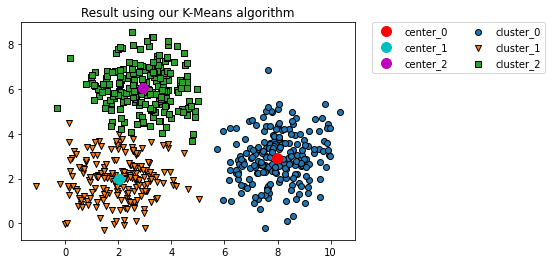

In [12]:
(centroids, labels, times) = kmeans(X_np, K)
print('Centers found by our algorithm:\n', centroids[-1])
X = X_np
y = labels[-1]
centers = centroids[-1]
label = np.unique(y)
marker = ['o', 'v', 's']
plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w'] # danh sách các màu hỗ trợ
#Minh hoạ kết quả
fig, ax = plt.subplots()
for i, m in zip(label, marker):
    ax.scatter(X[y == i][:, 0], X[y == i][:, 1], edgecolor='k', marker=m, label = 'cluster_' + str(i))
    ax.plot(centers[i][0], centers[i][1], plt_colors[i+2] + 'o', markersize = 10, label = 'center_' + str(i)) # Vẽ tâm cụm i lên đồ thị
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, borderaxespad=0.)
plt.title('Result using our K-Means algorithm')
plt.show()

Mô tả từng bước thực hiện thuật toán K-Means.

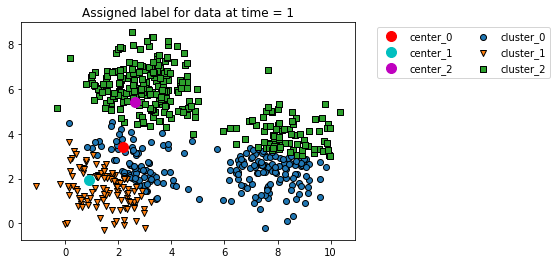

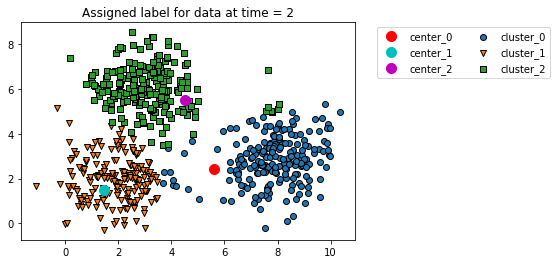

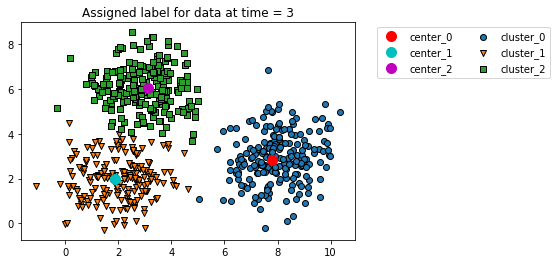

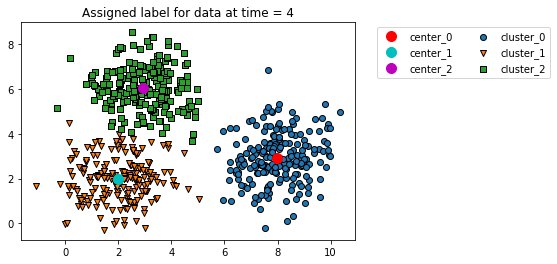

In [13]:
iters = range(times)
for time in iters:
    filename = 'Assigned label for data at time = ' + str(time + 1)
    X = X_np
    y = labels[time]
    centers = centroids[time]
    label = np.unique(y)
    marker = ['o', 'v', 's']
    plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w'] # danh sách các màu hỗ trợ
    #Minh hoạ kết quả
    fig, ax = plt.subplots()
    for i, m in zip(label, marker):
        ax.scatter(X[y == i][:, 0], X[y == i][:, 1], edgecolor='k', marker=m, label = 'cluster_' + str(i))
        ax.plot(centers[i][0], centers[i][1], plt_colors[i+2] + 'o', markersize = 10, label = 'center_' + str(i)) # Vẽ tâm cụm i lên đồ thị
    plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
    plt.title(filename)
    plt.show()

Từ kết quả này chúng ta thấy rằng thuật toán K-means Clustering làm việc khá thành công, các centroids tìm được khá gần với kỳ vọng ban đầu. Mặc dù màu sắc bị hoán đổi nhưng những điểm ban đầu thuộc cùng một cluster gần như vẫn cùng thuộc một cluster.

## Kết quả tìm được bằng thư viện scikit-learn
Một số thông số quan trọng trong hàm `sklearn.cluster.KMeans()`:
* `n_clusters` : `int`, mặc định = 8
    Số lượng cụm hình thành (số lượng centroids cầntạo).
* `init` : `{'k-means++', 'random'}`, mặc định là `'k-means++`
    Phương thức khởi tạo.
* `n_init` : `int`, mặc định = 10
    Số lần thuật toán K-Means chạy với bộ tâm khác nhau.
* `max_iter` : `int`, mặc định = 300
    Số lần lặp tối đa cho một lần chạy thuật toán.

In [14]:
from sklearn.cluster import KMeans # Khai báo thư viện K-Means
# Khởi tạo thuật toán K-Means với 3 cụm và các tâm cụm được tạo ngẫu nhiên
model = KMeans(n_clusters=3, init='random', random_state=rs)
# Áp dụng thuật toán K-Means lên dữ liệu X_np
model.fit(X_np)
print('Centers found by scikit-learn:')
# model.cluster_centers_ là hàm lấy tâm cụm sau khi thực hiện thuật toán K-Means
print(model.cluster_centers_)
# Dùng hàm model.predict để lấy ra kết quả phân cụm dữ liệu ban đầu sau khi thực hiện thuật toán K-Means
pred_label = model.predict(X_np)

Centers found by scikit-learn:
[[7.98642782 2.93618727]
 [2.00977268 1.97387946]
 [2.94030031 6.04919913]]


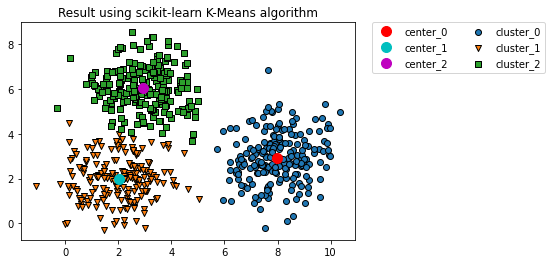

In [15]:
#Minh hoạ kết quả
X = X_np
y = pred_label
centers = model.cluster_centers_
labels = np.unique(y)
marker = ['o', 'v', 's']
plt_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w'] # danh sách các màu hỗ trợ
fig, ax = plt.subplots()
for i, m in zip(labels, marker):
    ax.scatter(X[y == i][:, 0], X[y == i][:, 1], edgecolor='k', marker=m, label = 'cluster_' + str(i))
    ax.plot(centers[i][0], centers[i][1], plt_colors[i+2] + 'o', markersize = 10, label = 'center_' + str(i)) # Vẽ tâm cụm i lên đồ thị
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, borderaxespad=0.)
plt.title('Result using scikit-learn K-Means algorithm')
plt.show()

Chúng ta thấy rằng hai thuật toán khác nhau cho cùng một đáp số.

## Thực thi thuật toán K-Means trên bộ dữ liệu thực
Trong phần này, ta sẽ sử dụng bộ dữ liệu `iris` từ thư viện `scikit-learn`

In [16]:
from sklearn.datasets import load_iris
#Load dữ liệu
data, original_label = load_iris(return_X_y=True, as_frame=True)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [17]:
print(">> Shape of data: ", data.shape)

>> Shape of data:  (150, 4)


## Phương pháp elbow giúp tìm số cụm tối ưu

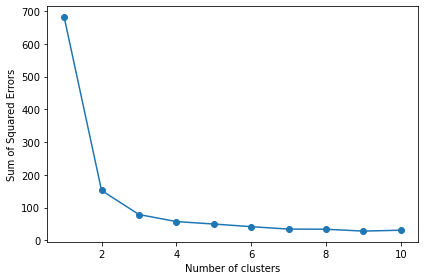

In [18]:
distortions = []
for i in range(1, 11):
    (centroids, labels, times) = kmeans(data, i)
    sse = SSE(data, centroids[-1])
    distortions.append(sse)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors')
plt.tight_layout()
plt.show()

Theo phương thức elbow thì tại `k = 3` (tức số cụm là 3) sẽ cho ra kết quả của thuật toán K-Means tốt nhất.

## Phương pháp xác định cụm tối ưu bằng silhouette plot

Giảm số chiều của dữ liệu về 2 chiều để trực quan hoá trên biểu đồ.

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Chuẩn hóa dữ liệu
sc = StandardScaler()
X_std = sc.fit_transform(data)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

Trực quan hoá biểu đồ `silhouette` để chọn ra số cụm tối ưu.

For n_clusters = 2 The average silhouette_score is : 0.6810461692117465
For n_clusters = 3 The average silhouette_score is : 0.5511916046195927
For n_clusters = 4 The average silhouette_score is : 0.41376681624285205
For n_clusters = 5 The average silhouette_score is : 0.45563368082588435


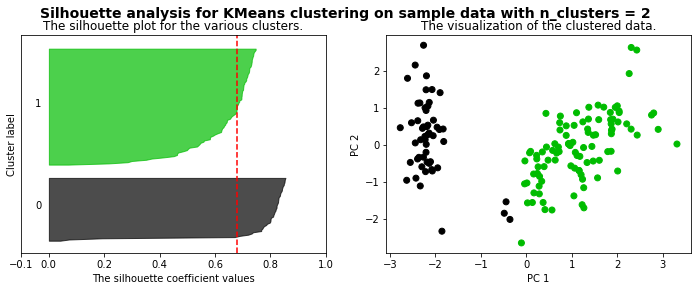

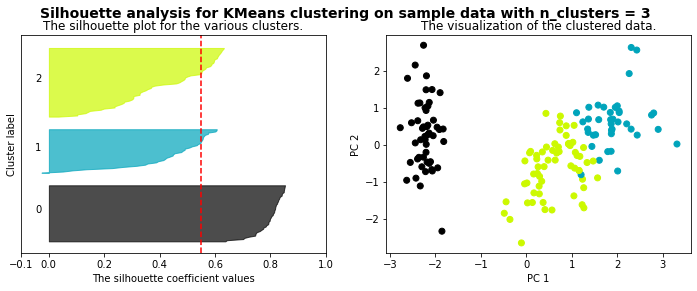

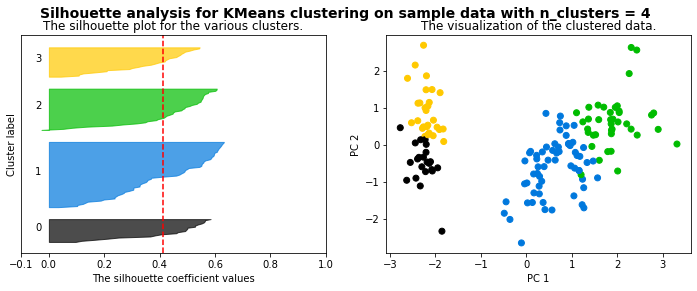

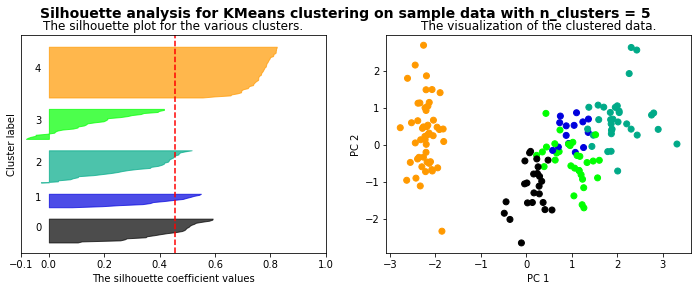

In [20]:
# Khai báo hàm thư viện của silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for n_clusters in range(2,6):
    # Khởi tạo subplot gồm 1 dòng, 2 cột 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    # Ô đầu tiên trong subplot là silhouette plot
    # Hệ số silhoutte có thể thuộc [-1,1] nhưng trong ví dụ này hệ số thuộc [-0.1,1]
    ax1.set_xlim([-0.1, 1])
    
    # (N_clusters + 1) * 10: để chèn khoảng trống giữa các silhouette plots để phân cách chúng một cách rõ ràng
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    
    # Khởi tạo clusters với giá trị n_clusters 
    (centroids, labels, times) = kmeans(data, n_clusters)
    y_predict = labels[-1]
    
    # Silhouette_score cho giá trị trung bình của tất cả các mẫu.
    # Điều này cho ta thấy về mật độ và sự tách biệt của các cụm
    silhouette_avg = silhouette_score(data, y_predict)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Tính silhouette scores cho mỗi mẫu
    sample_silhouette_values = silhouette_samples(data, y_predict)

    y_lower = 10
    for i in range(n_clusters):
        # Tổng hợp silhouette scores cho các mẫu thuộc về cụm i và sắp xếp chúng
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_predict == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
     
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Tính y_lower cho plot tiếp theo
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Đường thẳng nét đứt, màu đỏ là silhouette scores trung bình của tất cả các giá trị

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Xóa yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # Ô thứ 2 trong subplot hiển thị các cụm thực tế được hình thành
    colors = cm.nipy_spectral(y_predict.astype(float) / n_clusters)
    ax2.scatter(X_pca[:,0],
    X_pca[:,1] , c = colors)
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Theo phương thức silhouette thì tại `k = 3` (tức số cụm là 3) sẽ cho ra kết quả của thuật toán K-Means tốt nhất.

Như vậy, đối chiếu kết quả thì cả 2 phương pháp đều cho ra cùng đáp số là `k = 3`.

## Thực thi thuật toán K-Means bằng hàm tự xây dựng với số cụm vừa tìm được ở trên.

In [21]:
(centroids, labels, times) = kmeans(data, 3)
print('Centers found by our algorithm:\n', centroids[-1])

Centers found by our algorithm:
 [[5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]
 [5.006      3.428      1.462      0.246     ]]


## Thực thi thuật toán K-Means bằng hàm từ thư viện scikit-learn.

In [22]:
# Khởi tạo thuật toán K-Means với 3 cụm và các tâm cụm được tạo ngẫu nhiên
model = KMeans(n_clusters=3, init='random', random_state=rs)
# Áp dụng thuật toán K-Means lên dữ liệu data
model.fit(data)
print('Centers found by scikit-learn:')
# model.cluster_centers_ là hàm lấy tâm cụm sau khi thực hiện thuật toán K-Means
print(model.cluster_centers_)
# Dùng hàm model.predict để lấy ra kết quả phân cụm dữ liệu ban đầu sau khi thực hiện thuật toán K-Means
pred_label = model.predict(data)

Centers found by scikit-learn:
[[5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]
 [5.006      3.428      1.462      0.246     ]]


Từ kết quả này chúng ta thấy rằng *thuật toán K-means Clustering* cho ra kết quả gần giống với kết quả dùng hàm từ thư viện scikit-learn.

## So sánh kết quả

In [23]:
print(">> Original labels :")
label = np.array(original_label)
print(label)
print(">> Predicted labels using our algorithm :")
print(labels[-1])
print(">> Predicted labels found by scikit-learn :")
print(pred_label)

>> Original labels :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
>> Predicted labels using our algorithm :
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1
 1 0]
>> Predicted labels found by scikit-learn :
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0

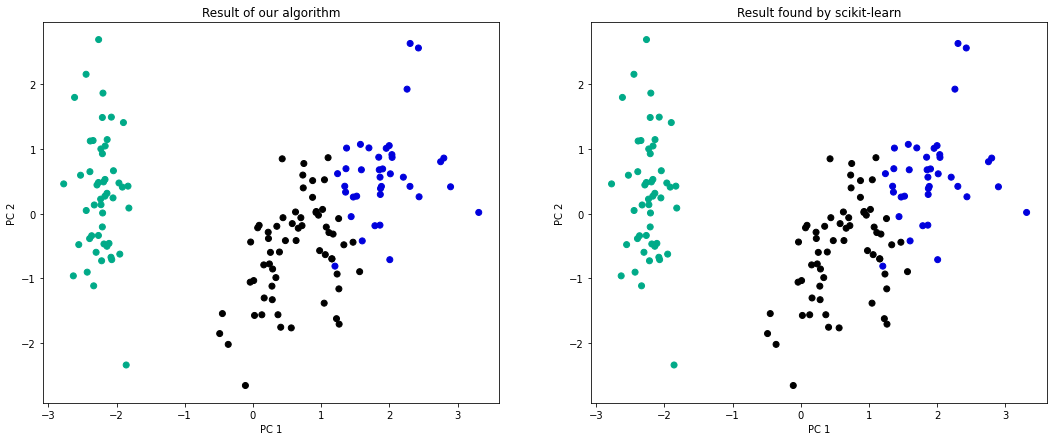

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
colors = cm.nipy_spectral(labels[-1].astype(float) / n_clusters)
ax1.scatter(X_pca[:,0], X_pca[:,1] , c = colors)

ax1.set_title("Result of our algorithm")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")

colors = cm.nipy_spectral(pred_label.astype(float) / n_clusters)
ax2.scatter(X_pca[:,0], X_pca[:,1] , c = colors)

ax2.set_title("Result found by scikit-learn")
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
plt.show()

Ta thấy rằng mặc dù ký hiệu nhóm không tương ứng giữa kết quả sau khi chạy *thuật toán K-Means* bằng cả 2 cách, nhưng các mẫu tương ứng thuộc cùng một cụm.

# Thuật toán K-Means++
## Nhắc lại các bước của thuật toán

1.  Khởi tạo một tập rỗng M để lưu trữ K tâm cụm.
2. Chọn ngẫu nhiên tâm cụm đầu tiền μ 1 từ các mẫu đầu vào và thêm nó vào M.
3. Đối với mỗi điễm dữ liệu x i không có trong M, tìm bình phương khoảng cách d(x i , M ) 2 đến bất kỳ tâm nào trong M.
4. Chọn ngẫu nhiên tâm cụm tiếp theo μ p bằng cách sử dụng phân phối xác suất có trọng số bằng $\frac{d(\mu, M)^2}{\sum_id(x_i, M)^2}$
5. Lặp lại bước 2 và 3 đến khi tìm đủ K tâm cụm.
6. Bây giờ các tâm cụm ban đầu đã được chọn, ta tiếp tục thực hiện các bước tiếp theo tương tựthuật toán K-Means cổ điển.

In [25]:
def cost(dist):
    """ 
    - Tính toán tổng bình phương chi phí (khoảng cách) từ dữ liệu đến các tâm hiện tại.
    - Các tham số:
    ------------------
    dist : np.ndarray
        Ma trận bình phương khoảng cách giữa dữ liệu và các tâm cụm hiện tại.
    - Trả về:
    ------------------
    Tổng bình phương chi phí (khoảng cách) từ dữ liệu đến các tâm cụm hiện tại (hằng số chuẩn hoá).
    """
    return np.sum(np.min(dist,axis=1))

def distribution(dist,cost):
    """ 
    - Tính toán phân bố để tạo ra các tâm cụm mới.
    - Các tham số:
    ------------------
    dist : np.ndarray
        Ma trận bình phương khoảng cách giữa dữ liệu và các tâm cụm hiện tại.
    cost : np.ndarray
        Tổng bình phương khoảng cách từ dữ liệu đến các tâm cụm hiện tại
    - Trả về:
    ------------------
    Danh sách các trọng số của phân phối.
    """
    return np.min(dist, axis=1)/cost

def sample_new(data,distribution,l):
    """ 
    - Chọn tâm cụm mới dựa trên trọng số của phân phối.
    - Các tham số:
    ------------------
    data : np.ndarray/DataFrame
        Dữ liệu đầu vào.
    distribution : np.ndarray
        Vector trọng số của các tâm cụm mới theo phân phối.
    l : int
        Số lượng tâm cụm mới cần lấy từ mẫu.
    - Trả về: 
    ------------------
    Các tâm cụm mới.                       
    """
    if isinstance(data, pd.DataFrame): # kiểm tra X có phải là 1 DataFrame hay không
        return data.loc[rnd.choice(range(len(distribution)),l,p=distribution),:]
    return data[rnd.choice(range(len(distribution)),l,p=distribution),:]

In [34]:
def KMeansPlusPlus(data, k):    
    """
    - Áp dụng kỹ thuật của thuật toán phân cụm K-Means++ để lấy các tâm cụm khởi tạo.
    - Các tham số:
    ------------------
    data : np.ndarray/DataFrame
        Dữ liệu đầu vào.
    
    k : int
        Số lượng tâm cụm cần tìm.
    - Trả về:
    ------------------
    centroids : np.ndarray
        Các tâm cụm khởi tạo thực hiện bởi thuật toán K-Means++
    """
    # Lấy ra tâm cụm đầu tiên
    if isinstance(data, pd.DataFrame): # kiểm tra X có phải là 1 DataFrame hay không
        centroids = data.loc[rnd.choice(data.shape[0],1),:]
    else:
        centroids = data[rnd.choice(data.shape[0],1),:]
    while centroids.shape[0] < k :  
        # Lấy bình phương khoảng cách giữa dữ liệu và các tâm cụm hiện tại
        dist = cdist(data, centroids)**2
        # Tính tổng bình phương khoảng cách từ dữ liệu đến các tâm cụm hiện tại
        norm_const = cost(dist)
        # Tính phân phối cho từng tâm cụm mới để lấy mẫu
        p = distribution(dist,norm_const)
        # Lấy ra một tâm cụm mới theo phân phối vừa tính và thêm vào centroids
        centroids = np.r_[centroids, sample_new(data,p,1)]
    return centroids

Phần chính của thuật toán K-Means++.

In [35]:
def kmeanspp(X, n_clusters):
    '''
    - Thực thi thuật toán K-Means++
    - Các tham số:
    ------------------
    X : numpy.ndarray
        Dữ liệu đầu vào.
        
    n_clusters : int
        Số tâm cụm (số cụm).
    - Trả về:
    ------------------
    centroids : numpy.ndarray
        Danh sách các tâm cụm sau mỗi lần thực thi thuật toán K-Means.
        
    labels : numpy.ndarray
        Danh sách nhãn của từng mẫu trong dữ liệu ban đầu sau mỗi lần thực thi thuật toán.
        
    times : int
        Số lần lặp lại bước 2 và 3 để cho ra kết quả cuối cùng.
    '''
    centroids = [KMeansPlusPlus(X, n_clusters)] # khởi tạo các tâm cụm ban đầu bằng kỹ thuật của thuật toán K-Means++
    labels = []
    times = 0 
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], n_clusters)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
        times += 1
    return (centroids, labels, times)

# Thực thi thuật toán K-Means++ trên bộ dữ liệu thực
Trong phần này, ta sẽ sử dụng bộ dữ liệu `iris` từ thư viện `scikit-learn`

In [28]:
from sklearn.datasets import load_iris
#Load dữ liệu
data, original_label = load_iris(return_X_y=True, as_frame=True)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [29]:
print(">> Shape of data: ", data.shape)

>> Shape of data:  (150, 4)


## Chọn số cụm tối ưu bằng phương pháp elbow

    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
38                4.4               3.0                1.3               0.2
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
131                7.9               3.8                6.4               2.0
[[7.9 3.8 6.4 2. ]
 [5.7 2.6 3.5 1. ]]
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
73                6.1               2.8                4.7               1.2
[[6.1 2.8 4.7 1.2]
 [5.1 3.8 1.5 0.3]]
[[6.1 2.8 4.7 1.2]
 [5.1 3.8 1.5 0.3]
 [7.2 3.  5.8 1.6]]
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
66                5.6               3.0                4.5               1.5
[[5.6 3.  4.5 1.5]
 [4.4 3.  1.3 0.2]]
[[5.6 3.  4.5 1.5]
 [4.4 3.  1.3 0.2]
 [4.9 2.4 3.3 1. ]]
[[5.6 3.  4.5 1.5]
 [4.4 3.  1.3 0.2]
 [4.9 2.4 3.3 1. ]
 [6.3 2.3 4.4 1.3]]
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width 

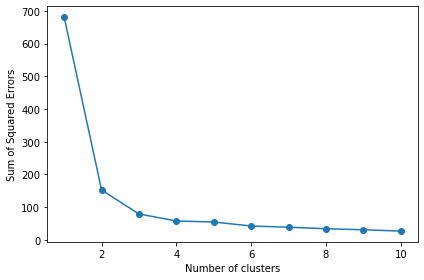

In [30]:
distortions = []
for i in range(1, 11):
    (centroids, labels, times) = kmeanspp(data, i)
    sse = SSE(data, centroids[-1])
    distortions.append(sse)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors')
plt.tight_layout()
plt.show()

# Chọn số cụm tối ưu bằng silhouette plot

Giảm số chiều của dữ liệu về 2 chiều để trực quan hoá trên biểu đồ.

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Chuẩn hóa dữ liệu
sc = StandardScaler()
X_std = sc.fit_transform(data)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

Trực quan hoá biểu đồ `silhouette` để tìm số cụm tối ưu.

    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
69                5.6               2.5                3.9               1.1
For n_clusters = 2 The average silhouette_score is : 0.6810461692117465
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
68                6.2               2.2                4.5               1.5
[[6.2 2.2 4.5 1.5]
 [5.  3.6 1.4 0.2]]
For n_clusters = 3 The average silhouette_score is : 0.5511916046195927
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
125                7.2               3.2                6.0               1.8
[[7.2 3.2 6.  1.8]
 [5.2 3.5 1.5 0.2]]
[[7.2 3.2 6.  1.8]
 [5.2 3.5 1.5 0.2]
 [5.6 2.7 4.2 1.3]]
For n_clusters = 4 The average silhouette_score is : 0.49535632852885064
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
32                5.2               4.1                1.5               0.1
[[5.2 4.1 1.5 0.1]
 [6.  3.  

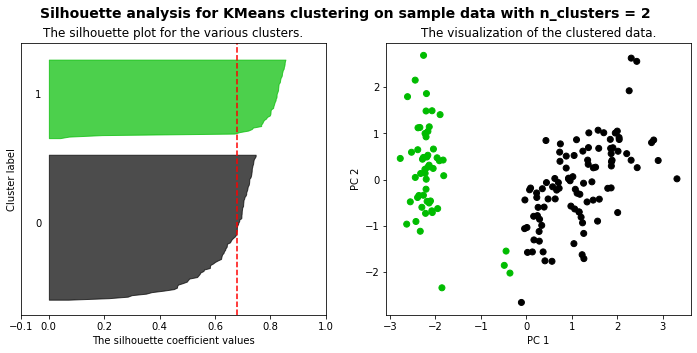

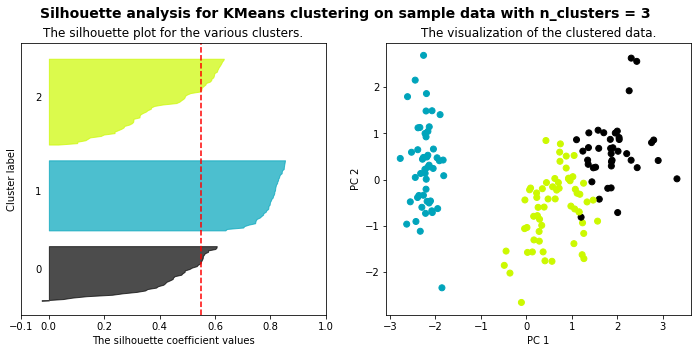

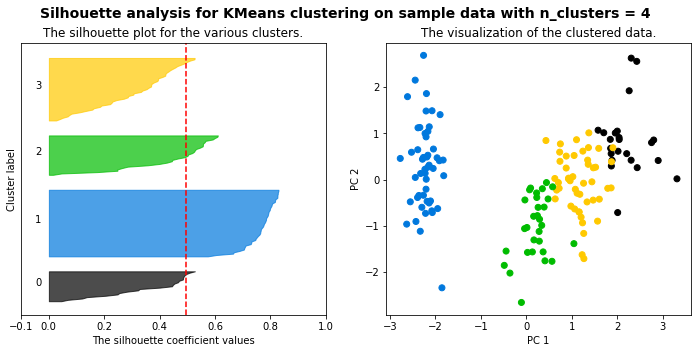

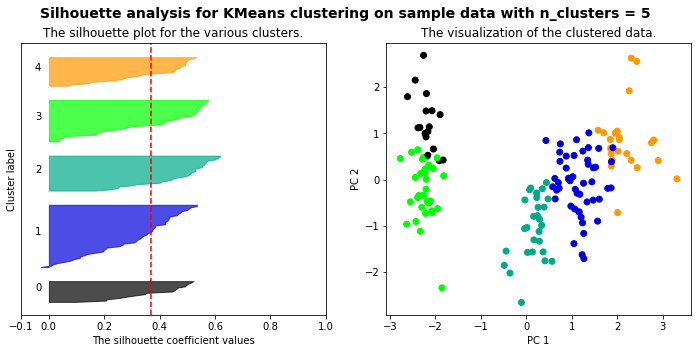

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
for n_clusters in range(2,6):
     # Khởi tạo subplot gồm 1 dòng, 2 cột 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)

    #Ô đầu tiên trong subplot là silhouette plot
    #Hệ số silhoutte có thể thuộc [-1,1] nhưng trong ví dụ này hệ số thuộc [-0.1,1]
    ax1.set_xlim([-0.1, 1])
    # (N_clusters + 1) * 10: để chèn khoảng trống giữa các silhouette plots để phân cách chúng một cách rõ ràng
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

   # Khởi tạo clusterer với giá trị n_clusters 
    (centroids, labels, times) = kmeanspp(data, n_clusters)
    y_predict = labels[-1]

    # Silhouette_score cho giá trị trung bình cho tất cả các mẫu.
    # Điều này cho ta thấy về mật độ và sự tách biệt của các cụm
    silhouette_avg = silhouette_score(data, y_predict)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

     # Tính silhouette scores cho mỗi mẫu
    sample_silhouette_values = silhouette_samples(data, y_predict)

    y_lower = 10
    for i in range(n_clusters):
        # Tổng hợp silhouette scores cho các mẫu thuộc về cụm i và sắp xếp chúng
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_predict == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Tính y_lower cho plot tiếp theo
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Đường thẳng nét đứt, màu đỏ là silhouette scores trung bình của tất cả các giá trị
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
   # Ô thứ 2 trong subplot hiển thị các cụm thực tế được hình thành
    colors = cm.nipy_spectral(y_predict.astype(float) / n_clusters)
    ax2.scatter(X_pca[:,0],
    X_pca[:,1] , c = colors)
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

## Thực thi thuật toán K-Means++ bằng hàm tự viết

In [36]:
(centroids, labels, times) = kmeanspp(data, 3)
print('Centers found by our algorithm:\n', centroids[-1])

1
2
Centers found by our algorithm:
 [[5.006      3.428      1.462      0.246     ]
 [5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]]


## Thực thi thuật toán K-Means++ bằng thư viện scikit-learn

In [34]:
# Khởi tạo thuật toán K-Means với 3 cụm và các tâm cụm được tạo bằng kỹ thuật K-Means++
model = KMeans(n_clusters=3, init='k-means++', random_state=rs)
# Áp dụng thuật toán K-Means lên dữ liệu data
model.fit(data)
print('Centers found by scikit-learn:')
# model.cluster_centers_ là hàm lấy tâm cụm sau khi thực hiện thuật toán K-Means++
print(model.cluster_centers_)
# Dùng hàm model.predict để lấy ra kết quả phân cụm dữ liệu ban đầu sau khi thực hiện thuật toán K-Means++
pred_label = model.predict(data)

Centers found by scikit-learn:
[[5.006      3.428      1.462      0.246     ]
 [5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]]


## So sánh kết quả

In [35]:
print(">> Original labels :")
label = np.array(original_label)
print(label)
print(">> Predicted labels using our algorithm :")
print(labels[-1])
print(">> Predicted labels found by scikit-learn :")
print(pred_label)

>> Original labels :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
>> Predicted labels using our algorithm :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]
>> Predicted labels found by scikit-learn :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1

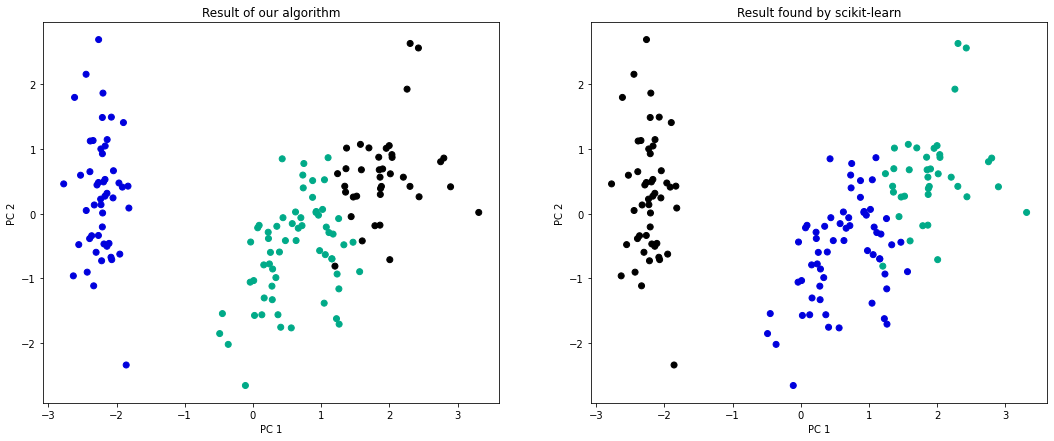

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
colors = cm.nipy_spectral(labels[-1].astype(float) / n_clusters)
ax1.scatter(X_pca[:,0], X_pca[:,1] , c = colors)

ax1.set_title("Result of our algorithm")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")

colors = cm.nipy_spectral(pred_label.astype(float) / n_clusters)
ax2.scatter(X_pca[:,0], X_pca[:,1] , c = colors)

ax2.set_title("Result found by scikit-learn")
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
plt.show()